In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("../final_1_lag_ffa_dataset.csv")


In [4]:
# Calculate fantasy points using STANDARD scoring
scoring = {
    "passing_yards": 1/25,
    "passing_tds": 4.0,
    "passing_interceptions": -2.0,
    "passing_2pt_conversions": 2.0,
    "sack_yards_lost": 0.0,
    "sack_fumbles_lost": -2.0,
    "rushing_yards": 1/10,
    "rushing_tds": 6.0,
    "rushing_fumbles_lost": -2.0,
    "rushing_2pt_conversions": 2.0,
    "receiving_yards": 1/10,
    "receiving_tds": 6.0,
    "receiving_fumbles_lost": -2.0,
    "receiving_2pt_conversions": 2.0,
    "misc_yards": 0.0,
}

def compute_fantasy_points(df, scoring):
    pts = (
        df.get("passing_yards", 0) * scoring["passing_yards"] +
        df.get("passing_tds", 0) * scoring["passing_tds"] +
        df.get("passing_interceptions", 0) * scoring["passing_interceptions"] +
        df.get("passing_2pt_conversions", 0) * scoring["passing_2pt_conversions"] +
        df.get("sack_yards_lost", 0) * scoring["sack_yards_lost"] +
        df.get("sack_fumbles_lost", 0) * scoring["sack_fumbles_lost"] +
        df.get("rushing_yards", 0) * scoring["rushing_yards"] +
        df.get("rushing_tds", 0) * scoring["rushing_tds"] +
        df.get("rushing_fumbles_lost", 0) * scoring["rushing_fumbles_lost"] +
        df.get("rushing_2pt_conversions", 0) * scoring["rushing_2pt_conversions"] +
        df.get("receiving_yards", 0) * scoring["receiving_yards"] +
        df.get("receiving_tds", 0) * scoring["receiving_tds"] +
        df.get("receiving_fumbles_lost", 0) * scoring["receiving_fumbles_lost"] +
        df.get("receiving_2pt_conversions", 0) * scoring["receiving_2pt_conversions"] +
        df.get("misc_yards", 0) * scoring["misc_yards"]
    )
    return pts

# Add fantasy_points column to your DataFrame
data["fantasy_points"] = compute_fantasy_points(data, scoring)
print(data[["fantasy_points"]].head())


   fantasy_points
0             0.0
1             0.0
2             0.0
3             0.0
4             0.0


In [5]:

# Drop rolling-average columns for windows other than 1 game
drop_ravg_other = [col for col in data.columns if 'r_avg_lag_1' in col and 'r_avg_1_lag_1' not in col]
if drop_ravg_other:
    print('Dropping non-1-window r_avg columns:', drop_ravg_other)
    data = data.drop(drop_ravg_other, axis=1)

# Drop unwanted columns but keep rolling averages for the 1-game window and season
protected = [col for col in data.columns if 'r_avg_1_lag_1' in col or col == 'season']
dropCols = [col for col in data.columns if (data[col].dtype == 'object' or 'id' in col or 'name' in col or 'team' in col) and col not in protected]
if dropCols:
    data = data.drop(dropCols, axis=1)

X = data.drop('fantasy_points_r_avg_1_lag_1', axis=1)
X = X.fillna(X.mean())
y = data['fantasy_points_r_avg_1_lag_1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

preds = model.predict(X_test_scaled)
print('Predictions:', preds[:5])
print('Score (R^2):', model.score(X_test_scaled, y_test))


Predictions: [14.33421112  3.31939421 10.85334318  7.21176056 12.30745816]
Score (R^2): 0.9989385274277018


In [6]:

print('y_test[:5]:', y_test.values[:5])
print('preds[:5]:', preds[:5])
residuals = y_test.values - preds
print('MSE:', mean_squared_error(y_test, preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, preds)))

y_test[:5]: [14.3   3.3  10.84  7.2  12.3 ]
preds[:5]: [14.33421112  3.31939421 10.85334318  7.21176056 12.30745816]
MSE: 0.05168259359909021
RMSE: 0.22733806016391142


Text(0.5, 1.0, 'Actual vs Predicted')

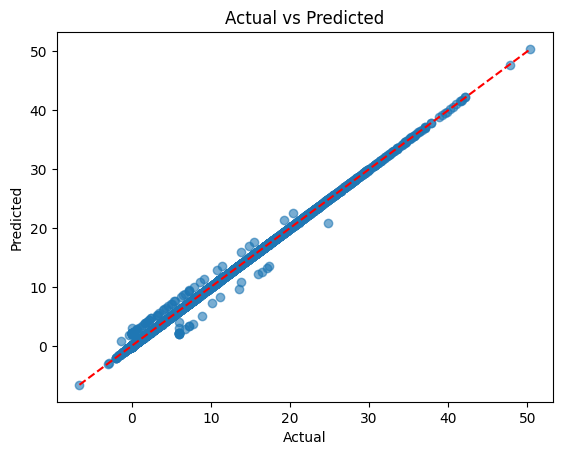

In [7]:

plt.scatter(y_test, preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect line
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Actual vs Predicted')

In [8]:

corrs = X_train.apply(lambda c: c.astype(float).corr(y_train) if c.dtype!='object' else 0)
corrs = corrs.abs().sort_values(ascending=False)
print('Top correlations with target:\n', corrs.head(20))

for col in X_train.columns:
    if (X_train[col].astype(str).sample(100, random_state=1).values == y_train.astype(str).sample(100, random_state=1).values).all():
        print('Possible exact match column:', col)


Top correlations with target:
 fantasy_points_r_avg_3_lag_1     0.836273
fantasy_points_r_avg_5_lag_1     0.802707
fantasy_points_r_avg_8_lag_1     0.787414
passing_tds_r_avg_1_lag_1        0.543786
passing_yards_r_avg_1_lag_1      0.522655
passing_tds_r_avg_3_lag_1        0.507132
passing_tds_r_avg_5_lag_1        0.500977
passing_tds_r_avg_8_lag_1        0.497874
passing_yards_r_avg_3_lag_1      0.495352
passing_yards_r_avg_5_lag_1      0.490064
passing_yards_r_avg_8_lag_1      0.488034
rushing_yards_r_avg_1_lag_1      0.459995
rushing_tds_r_avg_1_lag_1        0.459498
receiving_tds_r_avg_1_lag_1      0.449430
receiving_yards_r_avg_1_lag_1    0.413579
rushing_tds_r_avg_3_lag_1        0.405647
rushing_yards_r_avg_3_lag_1      0.400385
rushing_tds_r_avg_5_lag_1        0.395720
rushing_tds_r_avg_8_lag_1        0.391896
rushing_yards_r_avg_5_lag_1      0.386461
dtype: float64
